### Calculating Risk Measures

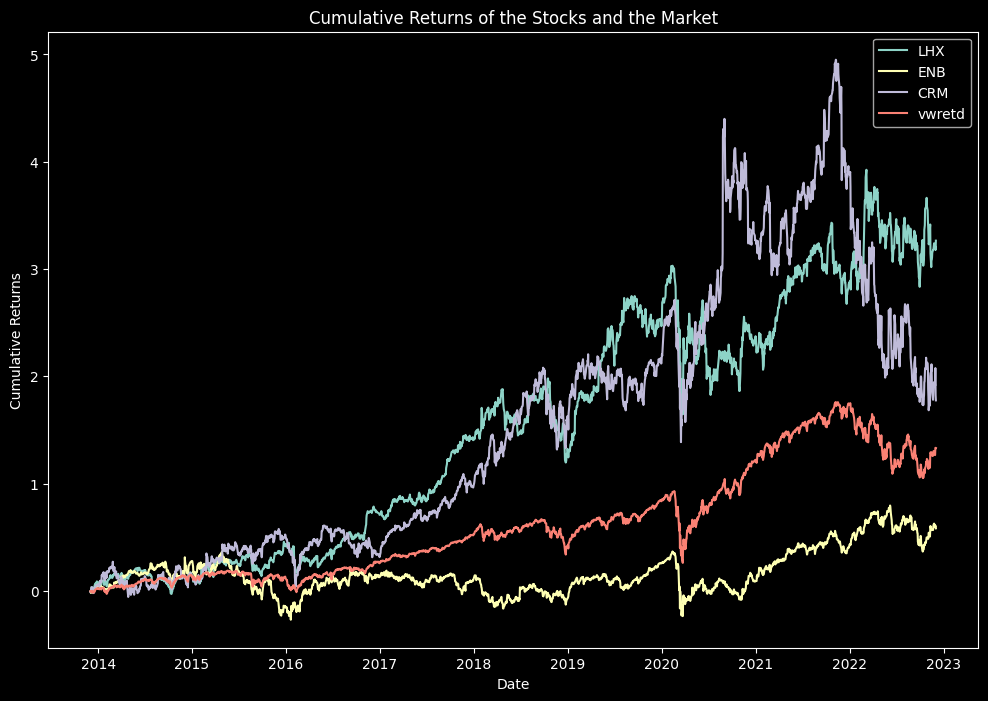

,LHX,ENB,CRM,vwretd
count,2268.000000,2268.000000,2268.000000,2268.000000
mean,0.000768,0.000354,0.000694,0.000437
std,0.016020,0.017395,0.022152,0.011239
min,-0.142994,-0.178327,-0.158885,-0.118168
25%,-0.006576,-0.007699,-0.008943,-0.003801
50%,0.000978,0.000629,0.000845,0.000675
75%,0.008304,0.008515,0.011462,0.005558
max,0.118680,0.191448,0.260449,0.091556


In [6]:
# import packages 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

# Formatting
returns_data = pd.read_csv('Data/Stocks and Market Returns.csv', index_col=0, parse_dates=True)

# Calculate cumulative returns of the stocks and market in order to plot them in a meaningful way
cumulative_returns = (1 + returns_data).cumprod() - 1

# Plot the cumulative returns
plt.figure(figsize=(12, 8))  # Set the figure size
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Cumulative Returns')  # Set the y-axis label
plt.title('Cumulative Returns of the Stocks and the Market')  # Set the title
plt.legend()  # Show the legend
plt.show()  # Display the plot

# Calculate descriptive statistics of the returns
returns_data.describe()

In [2]:
# Retrieve the cumulative return for '2022-12-02'
cumulative_return_on_2022_12_02 = cumulative_returns.loc['2022-12-02']
cumulative_return_on_2022_12_02

LHX       3.263849
ENB       0.582586
CRM       1.775165
vwretd    1.331466
Name: 2022-12-02 00:00:00, dtype: float64

Using Wharton Research Data Services, we collected data on the daily returns of a selection of stocks and a market indice between December 2, 2013 and December 2, 2022, covering nine years of returns. We chose three stocks: LHX and CRM, selected because their ticker begins with the same letter as the initials of our surname, and ENB, chosen because "E" is at the median of the alphabetical sequence between the first letters of our surnames. For market returns, we referred to "vwretd", which stands for value-weighted return, including distributions.

We plotted the cumulative returns of selected stocks, as it offers a more complete picture of performance over time than a simple time series of daily returns. In addition, we compiled basic statistical measures to provide an understanding of the return’s characteristics. These results are presented above or referenced in Table XX and Chart XX in the Appendix.

To compute the cumulative return, we employed the following approach:

$ CR_i = (1+R_1)(1+R_2)(1+R_3)\cdots (1+P_i) -1 $

- $CR_i$ = Cumulative return of stock i
- $R_i$ = Return of ith day

The average daily return was highest for LHX, at around 0.08%, followed by CRM at around 0.07%, with vwretd and ENB both at around 0.04%. This pattern suggests that, on average, LHX generated the highest daily return over the period under review. In terms of volatility, CRM showed the greatest volatility, with a standard deviation of around 2.2%, followed by ENB at 1.7%, LHX at 1.6% and vwretd at 1.1%. A larger standard deviation signifies greater risk associated with the stock's returns.

The trend depicted by the cumulative returns graph corroborates these conclusions, showing that CRM and LHX outperform the market but at the cost of greater volatility, with respective figures of around 44% and 193% versus the market from December 2nd, 2013, to December 2nd 2022. Conversely, ENB underperformed the market by around -75%, with slightly higher volatility, confirmed by its standard deviation.

### VaR and ES Estimates

In [3]:
# Define the function to calculate VaR and ES
def calculate_var_es(returns, alpha):
    VaR = np.quantile(returns, alpha)
    ES = returns[returns <= VaR].mean()
    return VaR, ES

    # Verify that alpha is within the correct range
    if not 0 < alpha < 1:
        raise ValueError()
    
    # Calculate VaR
    VaR = np.quantile(returns, alpha)

    # Calculate ES
    ES = np.mean(returns[returns<VaR])

    return VaR, ES


In [5]:
# Define the confidence level
alpha = 0.05 

# Calculate and print VaR and ES for each column
for column in returns_data.columns:
    var, es = calculate_var_es(returns_data[column].values, alpha)
    print(f"{column}: VaR: {var:.2%}, ES: {es:.2%}")

LHX: VaR: -2.37%, ES: -3.66%
ENB: VaR: -2.49%, ES: -3.90%
CRM: VaR: -3.44%, ES: -5.02%
vwretd: VaR: -1.69%, ES: -2.78%


Using data on stock and market returns, we have calculated historical estimates of Value at Risk (VaR) and Expected Shortfall (ES) at the 5% alpha level. This means that, if we held individual positions in stocks or the market, we would expect a minimum loss of 1.69%, 2.37%, 2.49% and 3.44% - occurring 5% of the time - for the market, LHX, ENB and CRM, respectively. If the loss exceeds the VaR (as shown above), the expected shortfall, or the average loss we expect to observe, would be 2.78%, 3.66%, 3.90% and 5.02% for each, in the same order as the VaR values. These results are consistent with the usual scenario in which individual stocks (such as LHX, ENB, CRM) present higher risks than a diversified market index.

In [15]:
# The Regression model
olsLHX = sm.OLS(returns_data['LHX'], sm.add_constant(returns_data['vwretd'])).fit()
olsENB = sm.OLS(returns_data['ENB'], sm.add_constant(returns_data['vwretd'])).fit()
olsCRM = sm.OLS(returns_data['CRM'], sm.add_constant(returns_data['vwretd'])).fit()

def calculate_var_ols(regression_results, p):
    """
    Calculate the Value at Risk (VaR) for the OLS fitted values assuming iid normal errors.

    Parameters:
    regression_results (RegressionResults): A RegressionResults object from statsmodels.
    p (float): The probability level, must be between 0 and 1.

    Returns:
    float: VaR value.
    """
    # Verify that p is within the correct range
    if not 0 < p < 1:
        raise ValueError("p must be between 0 and 1.")
    
    # Find the scale parameter from the regression model (standard deviation of the residuals)
    sigma_hat = regression_results.scale**0.5
    
    # Find the mean of the fitted values
    mean_fitted = regression_results.fittedvalues.mean()
    
    # Use the PPF of the normal distribution at the desired quantile
    VaR = mean_fitted + norm.ppf(p) * sigma_hat

    return VaR

In [17]:
p = 0.05  # For 95% confidence level

# Now using the function to calculate VaR for each regression result
VaR_LHX = calculate_var_ols(olsLHX, p)
VaR_ENB = calculate_var_ols(olsENB, p)
VaR_CRM = calculate_var_ols(olsCRM, p)

# Display the results
print(f"VaR for LHX at {alpha*100}% confidence level: {VaR_LHX:.2%}")
print(f"VaR for ENB at {alpha*100}% confidence level: {VaR_ENB:.2%}")
print(f"VaR for CRM at {alpha*100}% confidence level: {VaR_CRM:.2%}")

VaR for LHX at 5.0% confidence level: -2.15%
VaR for ENB at 5.0% confidence level: -2.24%
VaR for CRM at 5.0% confidence level: -2.68%
